# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
#from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import mne
from mne.viz import plot_topomap

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_7601/293465588.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_eeg_demo_data, load_eeg_demo_info#, load_eeg_demo_group_data
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.data import plot_topo_row
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
from apm.methods import (autocorr_decay_time, dfa, higuchi_fd, lempelziv, lyapunov,
                         sample_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, DFA_PARAMS, HFD_PARAMS, LZ_PARAMS,
                                  LY_PARAMS, SA_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Data Loading

In [4]:
# Define the data folder
folder = '/Users/tom/Data/VoytekLab/ExtractedSubsets/eeg_data'

In [5]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'eeg1'

In [6]:
# Define data field to extract from files
data_field = 'oz_rest_data'

In [7]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['eeg1_all_corrs.p',
 'eeg1_alpha_corr_diffs.p',
 'eeg1_alpha_corrs.p',
 'eeg1_group_alpha_corr_diffs.p',
 'eeg1_group_alpha_corrs.p',
 'eeg1_group_corrs.p',
 'eeg1_group_exp_corrs.p',
 'eeg1_group_results.p',
 'eeg1_group_results_peaks.p',
 'eeg1_peak_results.p',
 'eeg1_results.p']

## Settings

In [8]:
# Define data information
fs = 500
n_seconds = 120

In [9]:
# Define times vector for data
times = create_times(n_seconds, fs)

In [10]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [11]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = db.figs_path / '51_eeg_data'

## Load Data


In [12]:
# Get the list of available files
files = get_files(folder, select='.mat') 

In [13]:
# FIX: temporarily drop subject which has a data quirk (wrong size array)
files.remove('1009.mat')

In [14]:
# Check the number of subjects
n_subjs = len(files)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 28


In [15]:
# Load data
data = load_eeg_demo_data(files, folder, data_field)

## Data Checks

In [16]:
# Set example data index
data_ind = 12

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


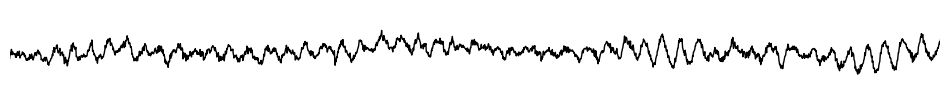

In [17]:
# Plot a segment of time series data
plot_time_series(times, data[data_ind, :], lw=1., xlim=[5, 10], figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [18]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[data_ind, :], fs, nperseg=2*fs, noverlap=fs)

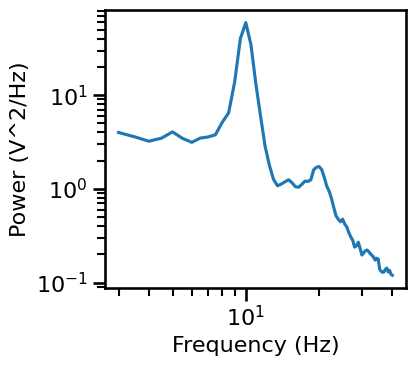

In [19]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

## Compute Measures

### Aperiodic Methods

In [20]:
# # General method settings
# f_range = [3, 40]
# specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : fs, 'f_range' : f_range}
# irasa_kwargs = {'fs' : fs, 'f_range' : f_range}

In [21]:
# # Initialize specparam model
# fm = FOOOF(verbose=False)

In [22]:
# # Define measures to apply, along with input parameters
# measures = {
#     autocorr_decay_time : AC_DECAY_PARAMS,
#     #hurst : HURST_PARAMS,
#     dfa : DFA_PARAMS,
#     higuchi_fd : HFD_PARAMS,
#     #hjorth_complexity : HJC_PARAMS,
#     lempelziv : LZ_PARAMS,
#     #lyapunov : LY_PARAMS,
#     sample_entropy : SA_ENT_PARAMS,
#     perm_entropy : PE_ENT_PARAMS,
#     specparam : specparam_kwargs,
#     irasa : irasa_kwargs,
# }

In [23]:
# # Compute measures of interest on the data
# results = run_measures(data, measures)

In [24]:
# Load precomputed measure results
results = load_pickle('eeg1_results', LOADPATH)

In [25]:
# # Compute correlations across all pairs of methods
# all_corrs = compute_all_corrs(results)

In [26]:
# Load precomputed measure correlations
all_corrs = load_pickle('eeg1_all_corrs', LOADPATH)

In [27]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

### Compare Exponent Measures

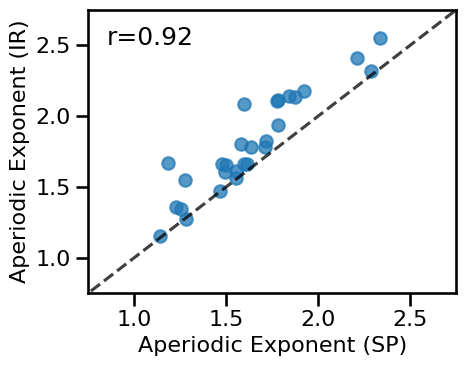

In [28]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, figsize=(5, 4),
          xlim=[0.75, 2.75], ylim=[0.75, 2.75], tposition='tl', expected=[0, 3],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [29]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.920  CI[+0.767, +0.980],  p=0.000


### Compare Exponent to TS Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


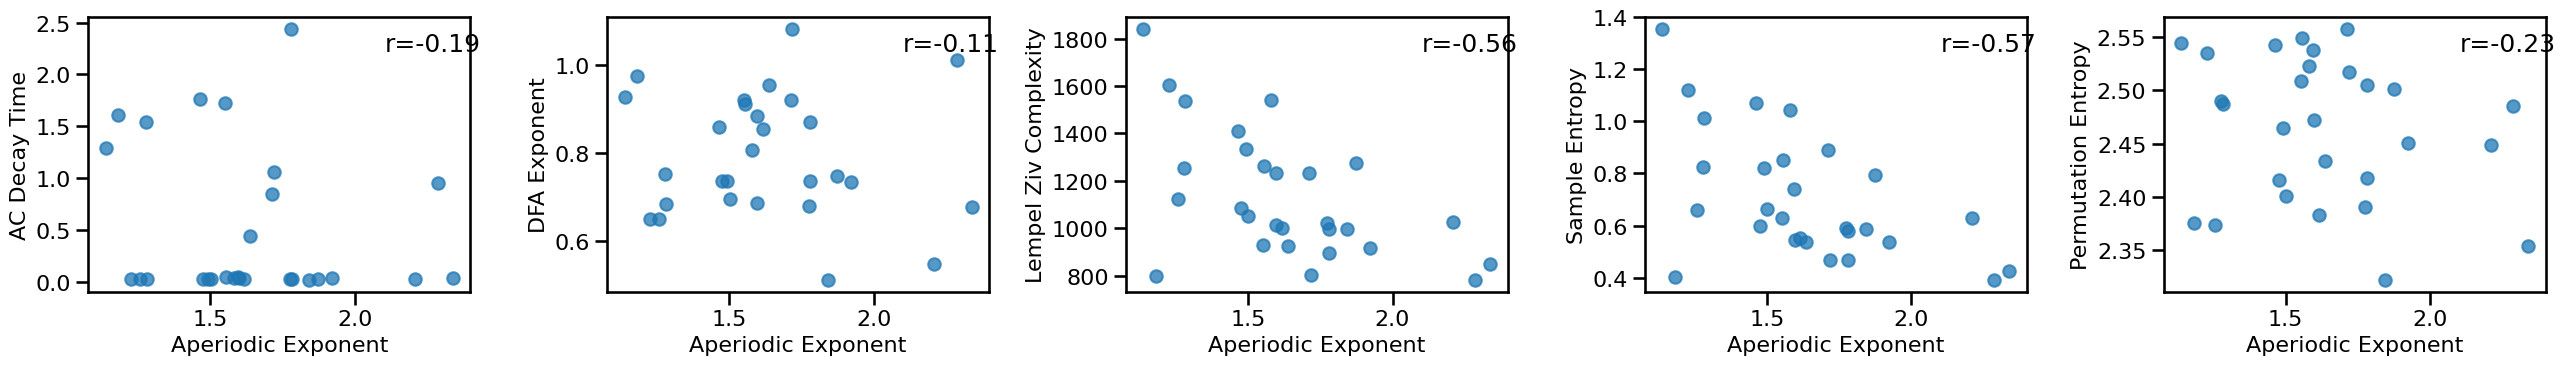

In [30]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.1)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [31]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=-0.193  CI[-0.552, +0.231],  p=0.324
    IR-EXP:   r=-0.175  CI[-0.563, +0.247],  p=0.372
dfa
    SP-EXP:   r=-0.112  CI[-0.524, +0.342],  p=0.570
    IR-EXP:   r=-0.137  CI[-0.553, +0.311],  p=0.486
lempelziv
    SP-EXP:   r=-0.561  CI[-0.844, -0.160],  p=0.002
    IR-EXP:   r=-0.649  CI[-0.845, -0.325],  p=0.000
sample_entropy
    SP-EXP:   r=-0.573  CI[-0.843, -0.171],  p=0.001
    IR-EXP:   r=-0.690  CI[-0.862, -0.416],  p=0.000
perm_entropy
    SP-EXP:   r=-0.228  CI[-0.577, +0.178],  p=0.243
    IR-EXP:   r=-0.383  CI[-0.670, -0.009],  p=0.044


### Compare Time Series Measures to Each Other

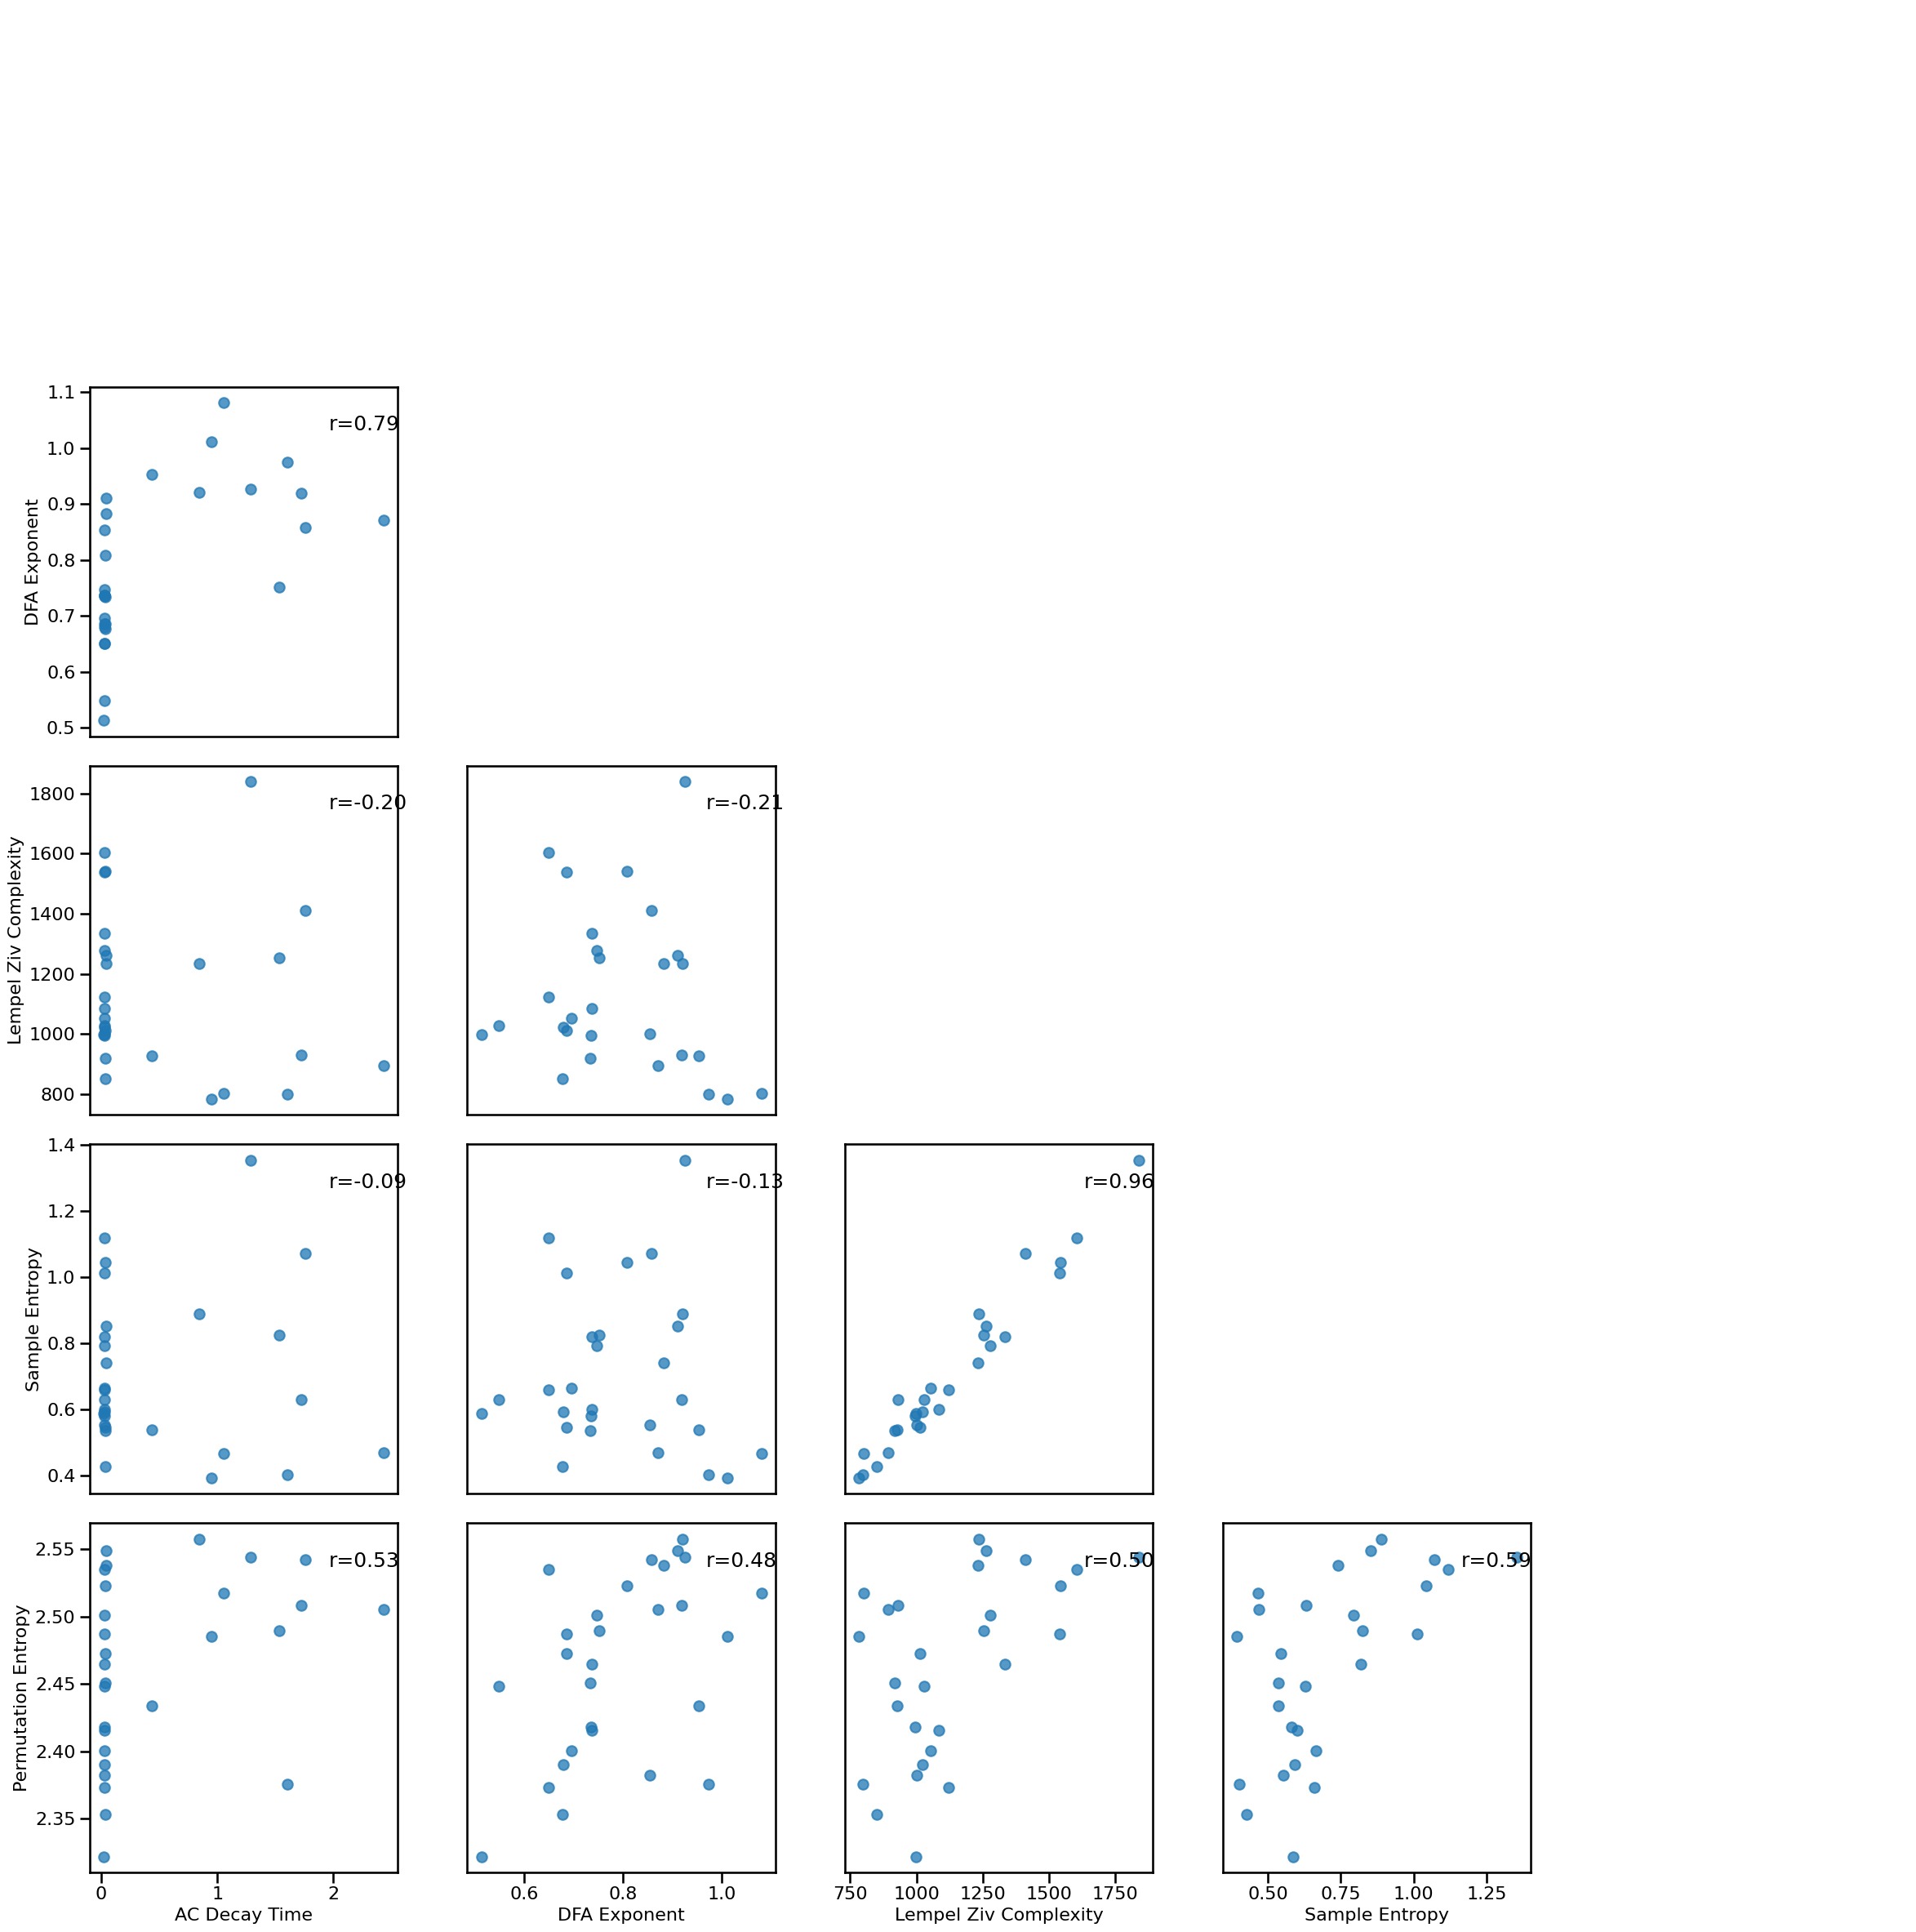

In [32]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

#### Correlations

In [33]:
# # ...
# all_corrs_ts = deepcopy(all_corrs)
# [all_corrs_ts.pop(meas) for meas in exp_measures];

In [34]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures}

In [35]:
# Unpack correlations for plotting
all_corrs_mat = unpack_corrs(all_corrs_ts)

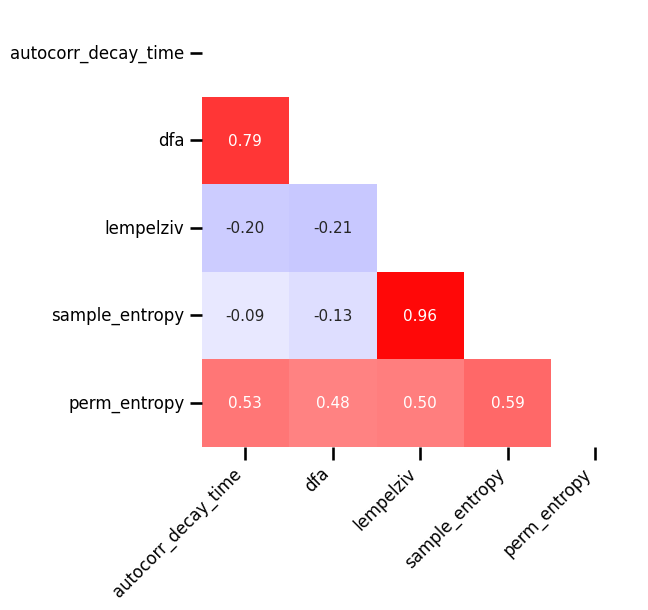

In [36]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(all_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [37]:
# exp_corrs_subjs = deepcopy(all_corrs['specparam'])
# exp_corrs_subjs.pop('irasa');
# exp_corrs_subjs = np.atleast_2d([exp_corrs_subjs[label][0] for label in ts_measures]).T

In [38]:
# Extract the correlations between specparam and time domain measures
exp_corrs_subjs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

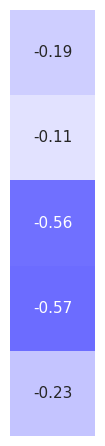

In [39]:
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_subjs' + EXT, file_path=FIGPATH)

### Compare to Alpha Power

In [40]:
# # Define periodic measures to compute
# peak_measures = {alpha_power : measures[specparam]}

In [41]:
# # Compute periodic measures
# peak_results = run_measures(data, peak_measures)

In [42]:
# Load precomputed peak measures
peak_results = load_pickle('eeg1_peak_results', LOADPATH)

In [43]:
# # Compute  
# alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [44]:
# Load precomputed correlations between aperiodic measures and alpha power
alpha_corrs = load_pickle('eeg1_alpha_corrs', LOADPATH)

In [45]:
# # Compute 
# alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [46]:
# Load precomputed differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = load_pickle('eeg1_alpha_corr_diffs', LOADPATH)

In [47]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=-0.812  CI[-0.903, -0.652],  p=0.000
     dfa                 :   r=-0.853  CI[-0.933, -0.698],  p=0.000
     lempelziv           :   r=+0.069  CI[-0.355, +0.464],  p=0.727
     sample_entropy      :   r=-0.020  CI[-0.438, +0.426],  p=0.921
     perm_entropy        :   r=-0.574  CI[-0.806, -0.246],  p=0.001
     specparam           :   r=+0.159  CI[-0.277, +0.550],  p=0.418
     irasa               :   r=+0.218  CI[-0.220, +0.596],  p=0.265


In [48]:
# ... 
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

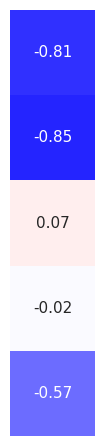

In [49]:
# ...
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_subjs' + EXT, file_path=FIGPATH)

## Topographies

In [50]:
# ...
path = Path('/Users/tom/Documents/Research/2-Projects/1a-Current(Voytek)/AperiodicMethods/2-Data/apm_data/')

In [51]:
# # Load group data
# group_data = load_eeg_demo_group_data(path)

In [52]:
# # TEST DATA - drop
# group_data = group_data[0:2, :, :]

#### Set up montage information

In [53]:
# Load MNE info object for the current dataset
info = load_eeg_demo_info(path)

#### Compute Measures Across Channels

In [54]:
# # ...
# group_results = run_group_measures(group_data, measures)

In [55]:
# Load precomputed group results
group_results = load_pickle('eeg1_group_results', LOADPATH)

In [56]:
# Compute the average across the group
group_avg = compute_avgs(group_results, np.nanmean)

#### Exponent Topograghies

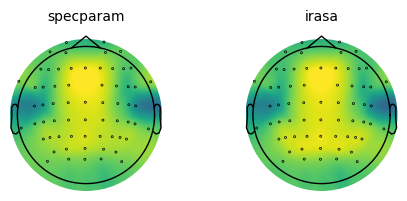

In [57]:
# Plot the group average topographies for the exponent measures
plot_topo_row(group_avg, exp_measures, info,
              save_fig=SAVE_FIG, file_name='exp_topos' + EXT, file_path=FIGPATH)

#### Time Series Measure Topographies

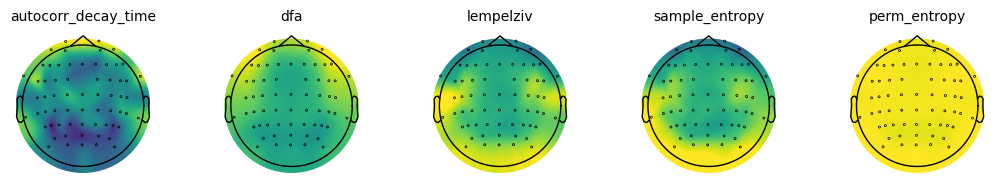

In [58]:
# Plot the group average topographies for the time domain measures
plot_topo_row(group_avg, ts_measures, info)

### Spatial Correlations

In [59]:
# # ...
# group_avg_ts = deepcopy(group_avg)
# [group_avg_ts.pop(meas) for meas in exp_measures];

In [60]:
# Subselect time domain measures
group_avg_ts2 = {ke : va for ke, va in group_avg.items() if ke not in exp_measures}

In [61]:
# # ...
# group_corrs = compute_all_corrs(group_avg_ts)

In [62]:
# Load precomputed group correlation results
group_corrs = load_pickle('eeg1_group_corrs', LOADPATH)

In [63]:
# Unpack correlations for plotting
group_corrs_mat = unpack_corrs(group_corrs)

In [64]:
# Organize correlations for plotting
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())
#short_labels = ['AC Decay', 'Hurst', 'DFA', 'Higuchi', 'LZC', 'HJC', 'SampE', 'PermE']
short_labels = [LABELS[meas] for meas in ts_measures]

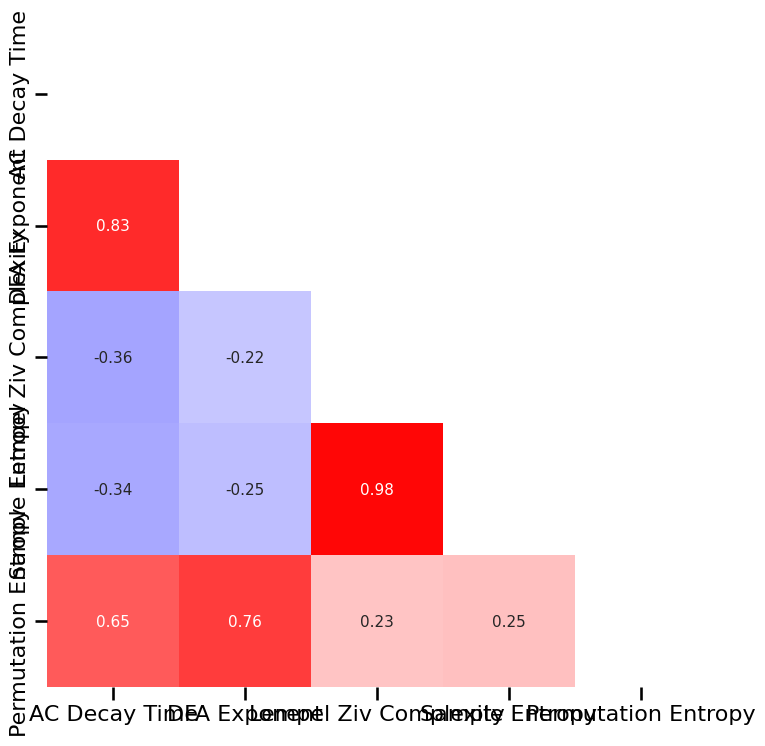

In [65]:
# Plot the correlation matrix spatial topographies
plot_corr_matrix(group_corrs_mat, xticklabels=short_labels, yticklabels=short_labels,
                 cbar=False, figsize=(8, 8),
                 save_fig=SAVE_FIG, file_name='ts_corr_mat' + EXT, file_path=FIGPATH)

In [66]:
# # ...
# group_exp_corrs = compute_corrs_to_feature(group_avg_ts, group_avg['specparam'])

In [67]:
# Load precomputed group exponent correlation results
group_exp_corrs = load_pickle('eeg1_group_exp_corrs', LOADPATH)

In [68]:
# Organize the correlations between the exponent and time domain measures
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

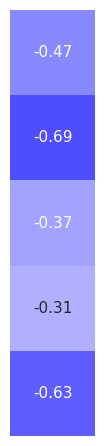

In [69]:
# Plot the correlations between exponent and time domain measures
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_space' + EXT, file_path=FIGPATH)

## Alpha Power Topography

In [70]:
# Load precomputed group alpha results
group_results_peaks = load_pickle('eeg1_group_results_peaks', LOADPATH)

In [71]:
# group_results_peaks = run_group_measures(group_data, peak_measures)

In [72]:
# group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [73]:
# Compute the average alpha topography across the group
group_avg_peaks = compute_avgs(group_results_peaks, np.nanmean)

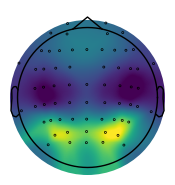

In [74]:
# Plot the average alpha topography across the group
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2, vlim=(-11.5, -10.5), show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_topo' + EXT))

In [75]:
# # Compute correlations 
# group_alpha_corrs = compute_corrs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [76]:
# Load precomputed correlations between aperiodic measures and alpha power
group_alpha_corrs = load_pickle('eeg1_group_alpha_corrs', LOADPATH)

In [77]:
# # Compute differences between correlations between aperiodic measures and alpha power
# group_alpha_corr_diffs = compute_diffs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [78]:
# Load precomputed differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = load_pickle('eeg1_group_alpha_corr_diffs', LOADPATH)

In [79]:
# Organize the alpha correlations
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

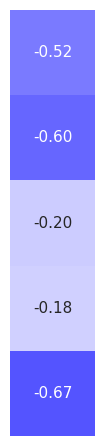

In [80]:
# Plot the correlations between alpha activity and other measures
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_space' + EXT, file_path=FIGPATH)

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.